https://www.kaggle.com/c/quora-question-pairs
# Поиск дупликатов вопросов
    Задача: необходимо определить какие из представленных пар вопросов содержат вопросы с одинаковым значением.
    
Файлы:
    train.csv - основной обучающий набор
    test.csv - тестовый набор
    sample_submission.csv - пример представления итогового результата

Поля данных:
    id - номер строки
    qid(1,2) - id вопросов
    question(1,2) - сам текст вопроса
    is_duplicate - дупликаты эти вопросы или нет


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

df_train = pd.read_csv(r'C:/Users/oleji/Desktop/dat/train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Всего вопросов из основного набора: 404290
Пары дупликата: 36.92%
Всего вопросов в обучающей выборке: 537933
Кол-во вопросов, которые появлялись несколько раз: 111780



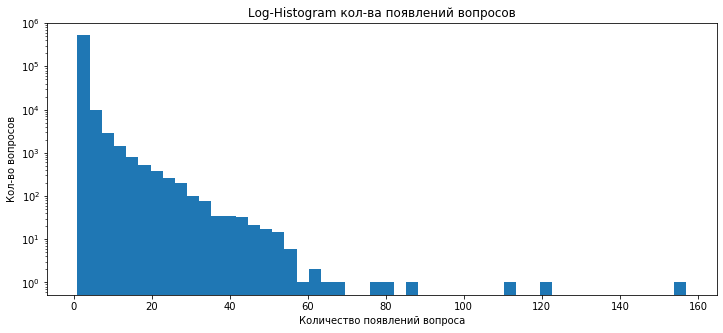

In [13]:
print('Всего вопросов из основного набора: {}'.format(len(df_train)))
print('Пары дупликата: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Всего вопросов в обучающей выборке: {}'.format(len(
    np.unique(qids))))
print('Кол-во вопросов, которые появлялись несколько раз: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram кол-ва появлений вопросов')
plt.xlabel('Количество появлений вопроса')
plt.ylabel('Кол-во вопросов')
print()

Большинство вопросов появляются только несколько раз, а несколько вопросов появляются много раз. Один вопрос появляется более 160 раз.

Мы можем видеть, что у нас есть 37% положительный класс в этом наборе данных.

In [8]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # наша вероятность
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

df_test = pd.read_csv(r'C:/Users/oleji/Desktop/dat/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('naive_submission.csv', index=False)
sub.head()

Predicted score: 0.6585273839844354


D:\Users\oleji\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,test_id,is_duplicate
0,0,0.369198
1,1,0.369198
2,2,0.369198
3,3,0.369198
4,4,0.369198


In [14]:
df_test = pd.read_csv(r'C:/Users/oleji/Desktop/dat/test.csv')
df_test.head()
print('Всего пар вопросов в тестовом наборе: {}'.format(len(df_test)))


Всего пар вопросов в тестовом наборе: 3563475


Текстовый анализ данных
Построим гистограмму для того, чтобы понять, что именно мы ищем.

D:\Users\oleji\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys
D:\Users\oleji\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


mean-train 59.82 std-train 31.96 mean-test 60.07 std-test 31.63 max-train 1169.00 max-test 1176.00


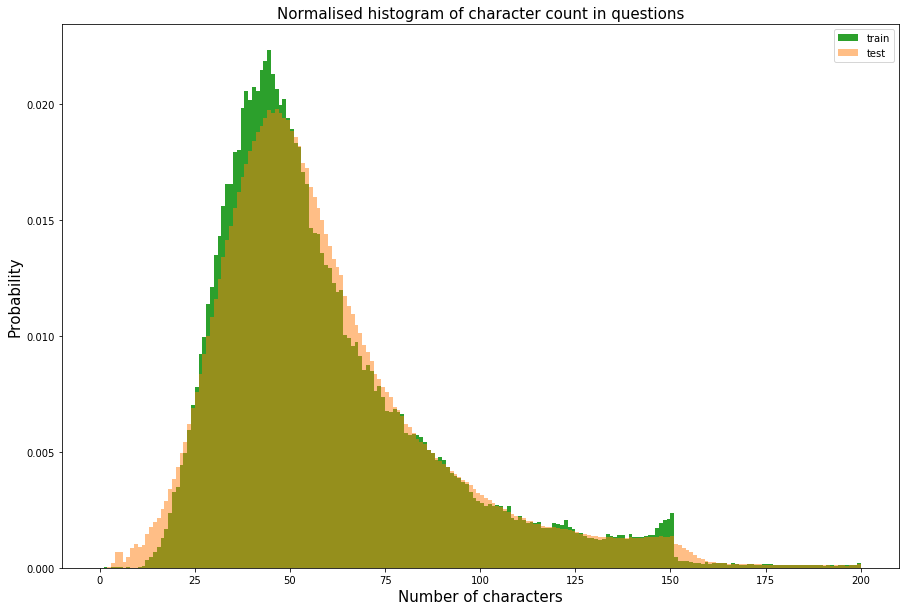

In [10]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Гистограмма кол-ва символов в вопросе', fontsize=15)
plt.legend()
plt.xlabel('Число символов', fontsize=15)
plt.ylabel('Вероятность', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

Мы видим, что большинство вопросов содержат от 15 до 150 символов. Кажется, что тестовое распределение немного отличается от основного, но не слишком сильно. Сделаем тоже самое для подсчета слов:

D:\Users\oleji\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
D:\Users\oleji\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


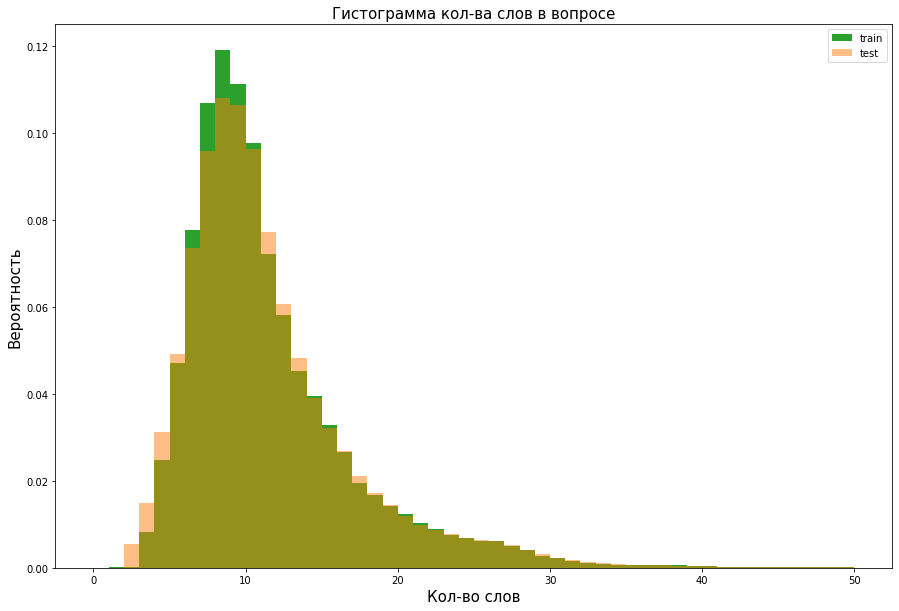

In [12]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Гистограмма кол-ва слов в вопросе', fontsize=15)
plt.legend()
plt.xlabel('Кол-во слов', fontsize=15)
plt.ylabel('Вероятность', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

Мы видим аналогичное распределение по количеству слов, большинство вопросов имеют длину около 10 слов.

Какие слова наиболее распространены? Посмотрим на облако слов.

(-0.5, 1439.5, 1079.5, -0.5)

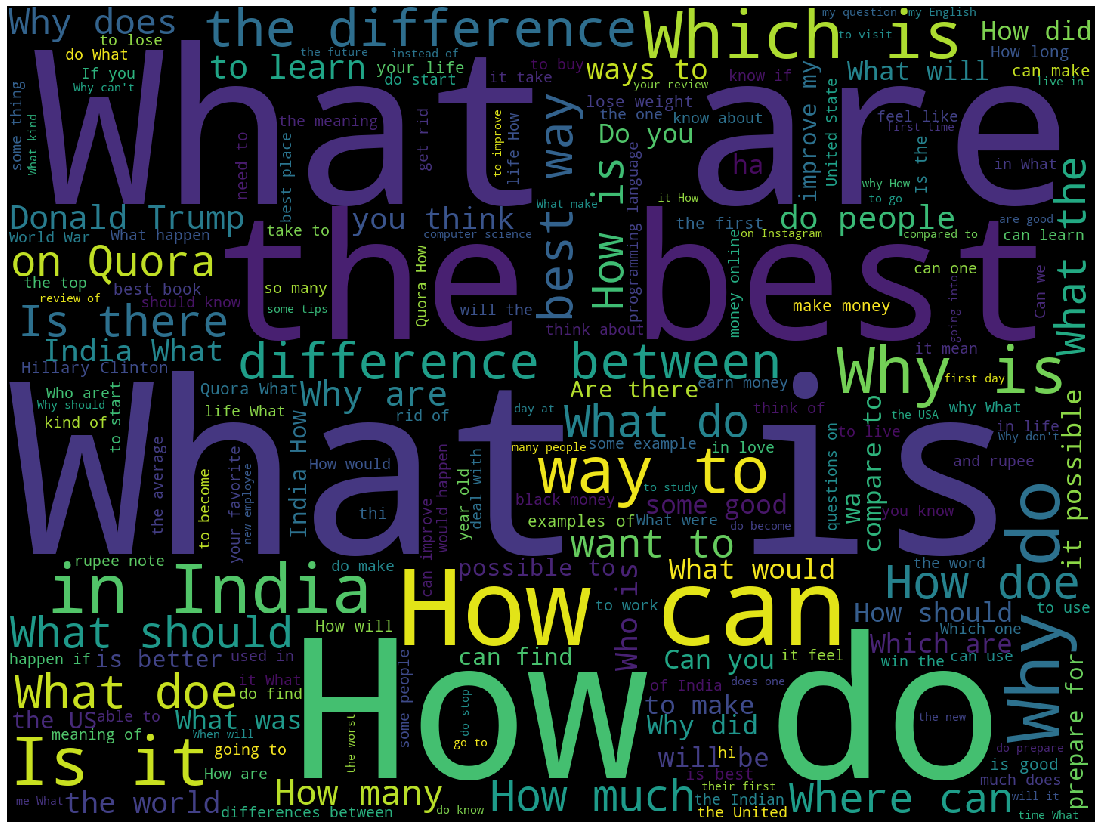

In [16]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

Рассмотрим дальше использование знаков препинания и регистров букв в вопросах

In [17]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Знак"?": {:.2f}%'.format(qmarks * 100))
print('Вопросы с матем. знаками: {:.2f}%'.format(math * 100))
print('Вопросы с точкой: {:.2f}%'.format(fullstop * 100))
print('Вопросы с первыми заглавными буквами: {:.2f}%'.format(capital_first * 100))
print('Вопросы с заглавными буквами: {:.2f}%'.format(capitals * 100))
print('Вопросы с цифрами: {:.2f}%'.format(numbers * 100))

Знак"?": 99.87%
Вопросы с матем. знаками: 0.12%
Вопросы с точкой: 6.31%
Вопросы с первыми заглавными буквами: 99.81%
Вопросы с заглавными буквами: 99.95%
Вопросы с цифрами: 11.83%


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oleji\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
D:\Users\oleji\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
D:\Users\oleji\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


Text(0.5, 0, 'word_match_share')

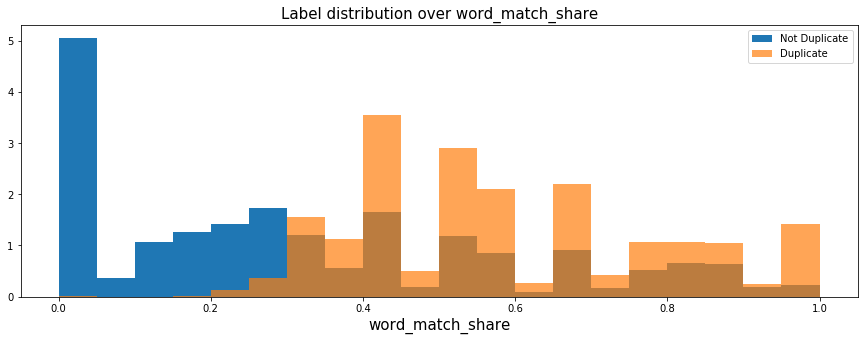

In [21]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # Cгенерированные основа, которая является стопсловами
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

Здесь мы можем видеть, что эта функция обладает достаточной предсказательной силой, так как она хороша для отделения дублирующих вопросов от не дублирующих. Этот метод кажется очень хорошим для определения вопросов, которые определенно отличаются, но не настолько хорош для поиска вопросов, которые однозначно дублируют друг друга.

Теперь взвесим термины по необычности, ищем более редкие слова, Например, "и" может быть в каждом вопросе, а слово "упражненение" или "задание" гораздо меньше.

In [22]:
from collections import Counter
# Если слово появляется только один раз, мы полностью его игнорируем (вероятно, опечатка)
# Эпсилон определяет константу сглаживания, что уменьшает эффект от очень редких слов
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}
print('Cамые используемые слова и их кол-во: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nCамые редкие слова и их кол-во: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Cамые используемые слова и их кол-во: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Cамые редкие слова и их кол-во: 


[('シ', 9.998000399920016e-05),
 ('し?', 9.998000399920016e-05),
 ('19-year-old.', 9.998000399920016e-05),
 ('1-855-425-3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('fab', 9.998000399920016e-05),
 ('109?', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05),
 ('fulfill?', 9.998000399920016e-05)]

Построим гистограмму с дупликатами и не снова, после пройденных шагов.

D:\Users\oleji\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
D:\Users\oleji\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
D:\Users\oleji\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


Text(0.5, 0, 'word_match_share')

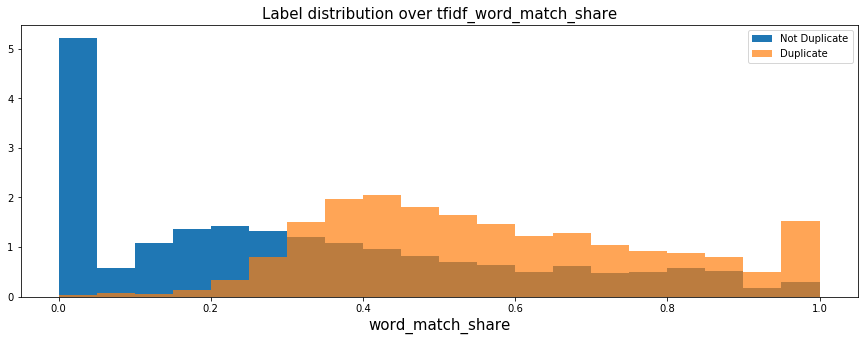

In [62]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R


plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [64]:
from sklearn.metrics import roc_auc_score
print(' AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

 AUC: 0.7804327049353577
   TFIDF AUC: 0.7704802292218704


# XGBoost
Перебалансируем данные, которые получает XGBoost, поскольку у нас 37% положительных результатов в наших данных обучения и только 17% в тестовых данных. Перебалансировав данные так, чтобы наш обучающий набор имел 17% положительных результатов, мы можем гарантировать, что XGBoost выведет вероятности, которые будут лучше соответствовать данным в таблице лидеров, и должны получить лучший результат (поскольку LogLoss рассматривает сами вероятности, а не только порядок предсказаний типа AUC)

In [65]:
y_train = df_train['is_duplicate'].values
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]


p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [66]:
from sklearn.model_selection import train_test_split
#разделим данные для валидации
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [67]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.683201	valid-logloss:0.683252
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.602145	valid-logloss:0.602636
[20]	train-logloss:0.545039	valid-logloss:0.545863
[30]	train-logloss:0.503375	valid-logloss:0.50444
[40]	train-logloss:0.47226	valid-logloss:0.473521
[50]	train-logloss:0.448638	valid-logloss:0.450059
[60]	train-logloss:0.430489	valid-logloss:0.432044
[70]	train-logloss:0.416379	valid-logloss:0.418048
[80]	train-logloss:0.405353	valid-logloss:0.407118
[90]	train-logloss:0.396699	valid-logloss:0.398544
[100]	train-logloss:0.389885	valid-logloss:0.391795
[110]	train-logloss:0.384474	valid-logloss:0.386436
[120]	train-logloss:0.380201	valid-logloss:0.382196
[130]	train-logloss:0.376799	valid-logloss:0.378823
[140]	train-logloss:0.374091	valid-logloss:0.376139
[150]	train-logloss:0.371912	valid-logloss:0.373981
[160]	train-logloss:0.370167	v

In [68]:
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices